## Supervised Spot Counting using a Random Forest Classifier

In [37]:
import os
import napari
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage import io, filters, img_as_ubyte, morphology
from skimage.segmentation import watershed, clear_border
from skimage.measure import regionprops, label
from skimage.exposure import adjust_gamma, rescale_intensity
from skimage.future import fit_segmenter, predict_segmenter 
from skimage.feature import multiscale_basic_features, hessian_matrix_eigvals

from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from functools import partial
from itertools import combinations_with_replacement

from scipy.ndimage import gaussian_laplace

Here we define the location of our images. We assume the following format for each 
file in each folder: 

{initials}-{session}-{plate number}-{well location}-{site}-{wavelength}.TIF

Each label has the following format. New additions to this set much follow the same format.

{initials}-{session}-{plate number}-{well location}-{site}-labels.TIF

In [4]:
# Directories where images are stored
POLYICNO_DIR = '-condensates_11757-11758_polyICno'
POLYICYES_DIR = '+condensates_11757-11758_polyICyes'
LABELS_DIR = 'labels'
TEST_DIR = 'KRD-MOA-OC43-220310-3720-22-1_Plate_13187/TimePoint_1'

### WellSite Class

The following class is defined as an analog to the individual well sites.

In [107]:
# Define class for each image set belonging to a particular plate, well, and site location
class WellSite():
    def __init__(self, name, wavelength_dir, labels_dir=LABELS_DIR):
        self.wavelength_dir=wavelength_dir
        self.labels_dir=labels_dir
        self.name = name
        self.__retrieve_wavelengths()
        self.__retrieve_labels()
        self.mask = None
        
    def __retrieve_wavelengths(self):
        wavelengths = []
        for wavelength_str in ['w1', 'w2', 'w3']:
            dir_name = os.path.join(self.wavelength_dir, self.name+'_'+wavelength_str+'.TIF')
            try:
                wavelengths.append(io.imread(dir_name))
            except: 
                print("File with given plate/well/site/directory does not exist.")
        self.wavelengths = wavelengths
        
    def __retrieve_labels(self):
        file_name = self.name+'_labels.TIF'
        dir_name = os.path.join(self.labels_dir, file_name)
        labels = None
        try:
            labels = io.imread(dir_name)
        except: 
            pass
        self.labels = labels 
    
    def __create_nuclei_mask(self):
        # apply thresholding to find nuclei. threshold_otsu 
        # was chosen through experimentation
        thresh = filters.threshold_otsu(self.wavelengths[0])
        mask = self.wavelengths[0] > thresh

        # remove holes and small objects
        mask = morphology.remove_small_holes(mask)
        mask = morphology.remove_small_objects(mask, min_size=2000)

        self.nuclei_mask = mask

    def __create_cell_mask(self):
        # apply thresholding to find cytoplasm. threshold_triangle
        # was chosen through experimentation.
        thresh = filters.threshold_triangle(self.wavelengths[2])
        mask = self.wavelengths[2] > thresh

        # remove holes and small objects. Use a greater minimum size when
        # removing holes.
        mask = morphology.remove_small_holes(mask)
        mask = morphology.remove_small_objects(mask, min_size=3000)

        self.cell_mask = mask
    
    def __get_num_cells_with_condensates(self, mask, labels):
        rprops = regionprops(mask)
        label_nums = [rprop.label for rprop in rprops]
        cells_with_condensates = 0

        for label_num in label_nums:
            individual_cell_mask = (mask == label_num)
            rprops = regionprops(label((labels > 1) * individual_cell_mask))

            if len(rprops) > 0:
                cells_with_condensates += 1

        return cells_with_condensates

    # Returns a dictionary containing properties on the prediction
    def get_properties(self, labels):
        if self.mask is None:
            self.create_mask()

        props = {}

        # Constants
        UM_PER_PIXEL = 0.1747

        # skimage regionprops object list
        condensate_mask = (labels > 1) * self.mask
        labeled_condensate_mask = label(condensate_mask)
        rprops = regionprops(labeled_condensate_mask, intensity_image=self.wavelengths[1])
      
        # Define properties
        well_site = self.name
        num_cells = len(regionprops(self.mask))
        num_cells_with_condensates = self.__get_num_cells_with_condensates(self.mask, labels)
        num_condensates = len(rprops)
        num_condensates_per_cell = None
        if num_cells_with_condensates > 0:
            num_condensates_per_cell = np.around(num_condensates / num_cells_with_condensates, 2)
        
        avg_condensate_area = None
        if num_condensates > 0:
            avg_condensate_area = np.around(
                sum([prop.area for prop in rprops]) / num_condensates * UM_PER_PIXEL, 3)
            
        avg_condensate_intensity = None
        if num_condensates > 0:
            avg_condensate_intensity = np.around(
                (sum([prop.intensity_mean for prop in rprops]) / num_condensates) / 65535, 3)

        props['well_site'] = well_site
        props['num_cells'] = num_cells
        props['num_cells_with_condensates'] = num_cells_with_condensates
        props['num_condensates'] = num_condensates
        props['avg_condensates_per_cell'] = num_condensates_per_cell
        props['avg_condensate_area'] = avg_condensate_area
        props['avg_condensate_intensity'] = avg_condensate_intensity

        return props
    
    def display_wavelengths(self):
        wavelengths = self.wavelengths
        fig, axs = plt.subplots(1, len(wavelengths), figsize=(20, 25))
        for i in range(len(wavelengths)):
            img = adjust_gamma(wavelengths[i], 0.1)
            axs[i].set_title(self.name + '_w'+str(i+1))
            axs[i].imshow(img)
        fig.tight_layout()
        plt.show()
    
    def display_labels(self, labels, xlim=None, ylim=None):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(adjust_gamma(self.wavelengths[1], 0.1))
        ax.contourf(labels, alpha=0.5)
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)
        plt.show()

    def __show_img(self, img, rescale=False, adjust=True, xlim=None, ylim=None):
        _, ax = plt.subplots(figsize=(10, 10))
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)
        if rescale:
            img = rescale_intensity(img, (0, 255))
        if adjust:
            img = adjust_gamma(img, 0.1)
        ax.imshow(img)
        plt.show()
        
    def generate_features(self, 
        sigma_min=0.01, sigma_max=8, num_sigma=None, show_features=False, xlim=None, ylim=None):

        if num_sigma is None:
            num_sigma = int(np.log2(sigma_max) - np.log2(sigma_min) + 1)
        sigmas = np.logspace(
            np.log2(sigma_min),
            np.log2(sigma_max),
            num=num_sigma,
            base=2,
            endpoint=True,
        )

        print(sigmas)

        fs = ()
        for sigma in sigmas:
            LoG = filters.laplace(filters.gaussian(self.wavelengths[1], sigma))
            fs += (LoG.T, )

        features = np.swapaxes(np.array(fs), 0, 2)
        
        if show_features:
            self.__show_img(self.wavelengths[1], xlim=xlim, ylim=ylim)
            for feature in np.swapaxes(features, 0, 2):
                self.__show_img(feature.T, rescale=True, xlim=xlim, ylim=ylim)

        return features

    def create_mask(self, show_process=False):
        wavelengths = self.wavelengths

        # create cell (cytoplasm) and nuclei masks
        self.__create_nuclei_mask()
        self.__create_cell_mask()

        # Segment cells using nuclei as labels
        nuclei = skimage.measure.label(self.nuclei_mask)
        segments_watershed = watershed(~self.cell_mask, nuclei, mask=self.cell_mask, watershed_line=True)

        # Clear borders; remove cells that are cut off by the border
        self.mask = clear_border(segments_watershed)
        self.pre_mask = np.copy(self.mask)
        
        # Determines regions (cells) that overlap with bright spots in the image
        mean = np.mean(wavelengths[1])
        std = np.std(wavelengths[1])
        self.outlier_mask = wavelengths[1] > mean + 5 * std
        self.outlier_mask = morphology.binary_opening(self.outlier_mask, morphology.disk(15))
        
        regions_to_remove = set((self.mask * self.outlier_mask).flatten())
        
        # Remove regions
        for label in regions_to_remove:
            if label != 0:
                self.mask = self.mask * (self.mask != label)
        
        # Plot individual steps for illustration purposes
        if show_process: 
            self.__show_img(self.wavelengths[1])
            self.__show_img(img_as_ubyte(self.pre_mask), adjust=False)
            self.__show_img(img_as_ubyte(self.outlier_mask), adjust=False)
            self.__show_img(img_as_ubyte(self.mask), adjust=False)
        

Here we use the two methods from above to create the masks themselves. After identifying cells using a watershed algorithm, we remove those that are cut off by a border. Plots of this process applied to a single well are shown. The results are satisfactory, despite the suboptimal separation of cells. This part is done mainly to identify cells that are cut off from the edges of the image. In terms of calculating the average number of spots per cell, the separations do not contribute error to this figure.

### Step 1: Use Napari to label images. 
This git repository includes a set of labels.

In [5]:
# Use napari as image viewer. 
# e.g.,

# wellSite = WellSite('KRD-MOA-OC43-220310-3720-22-1_I05_s3', TEST_DIR)
# napari.view_image(wellSite.wavelengths[1])

### Step 2: Train and test Random Forest Classifier model labeled well sites
Here we use our labeled images and break up the set into training and testing data.


In [108]:
# Divide labeled data into training and testing set
labeled_well_sites = [
                    #   ('KRD-MOA-OC43-220310-3720-22-1_A07_s2', TEST_DIR), \
                      ('KRD-211028-p6_G24_s3', POLYICYES_DIR), \
                      ('KRD-211028-p6_G24_s4', POLYICYES_DIR), \
                      ('KRD-211028-p6_K24_s4', POLYICYES_DIR), \
                      ('KRD-211028-p6_K24_s6', POLYICYES_DIR), \
                      ]
train_set = labeled_well_sites
test_set = labeled_well_sites[3:]

# Define a classifier
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)

# Train on training labeled well sites
print("## Train ##")
for args in train_set:
    wellSite = WellSite(*args)
    print('\nTraining on labels for: '+wellSite.name)
    start = time.time()
    clf.set_params(n_estimators=clf.n_estimators + 30)
    clf = fit_segmenter(wellSite.labels, wellSite.generate_features(), clf)
    end = time.time()
    print('Completed. Time elapsed: '+str(np.around(end - start, 2))+'s')
    


## Train ##

Training on labels for: KRD-211028-p6_G24_s3
[1. 2. 4. 8.]
Completed. Time elapsed: 1.83s

Training on labels for: KRD-211028-p6_G24_s4
[1. 2. 4. 8.]
Completed. Time elapsed: 1.94s

Training on labels for: KRD-211028-p6_K24_s4
[1. 2. 4. 8.]
Completed. Time elapsed: 2.95s

Training on labels for: KRD-211028-p6_K24_s6
[1. 2. 4. 8.]
Completed. Time elapsed: 2.3s


Predicting labels for: KRD-211028-p5_G24_s4
[1. 2. 4. 8.]


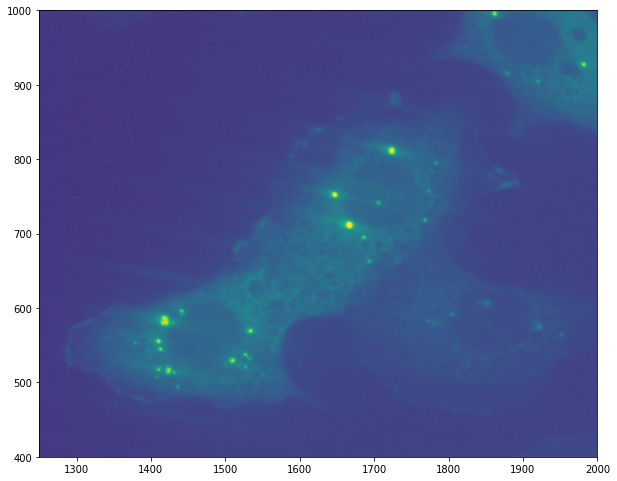

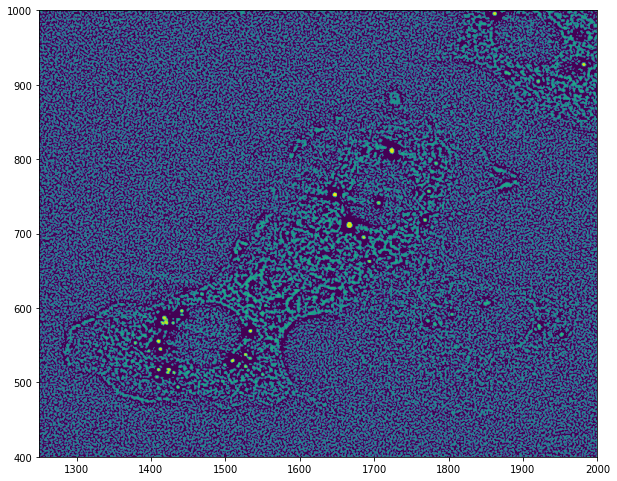

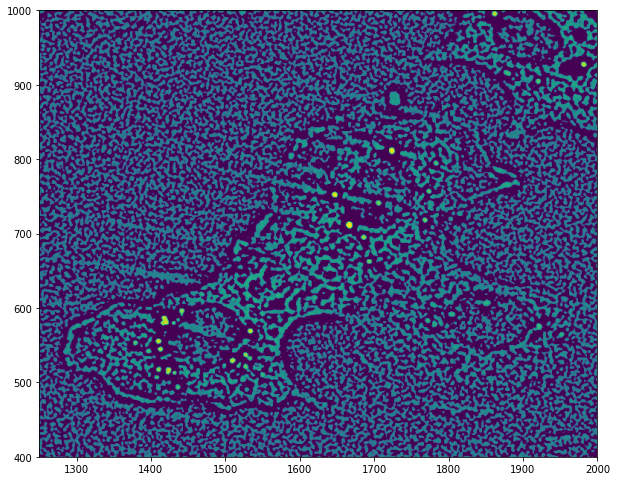

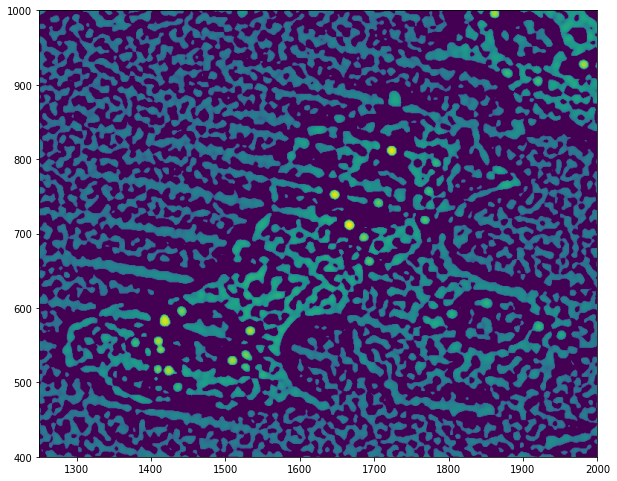

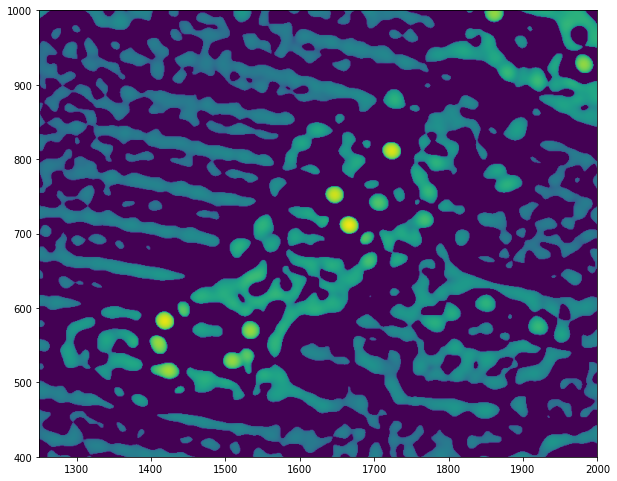

Completed. Time elapsed: 17.24s
Properties:
    well_site: KRD-211028-p5_G24_s4
    num_cells: 14
    num_cells_with_condensates: 14
    num_condensates: 218
    avg_condensates_per_cell: 15.57
    avg_condensate_area: 2.495
    avg_condensate_intensity: 0.076


In [109]:
#
# This snippet is for running measurement on a single well site
#
well_site = ('KRD-211028-p5_G24_s4', POLYICYES_DIR)
wellSite = WellSite(*well_site)

print('Predicting labels for: '+wellSite.name)
start = time.time()

features = wellSite.generate_features(show_features=False, xlim=(1250, 2000), ylim=(400, 1000))
pred_labels = predict_segmenter(features, clf)

end = time.time()
print('Completed. Time elapsed: '+str(np.around(end - start, 2))+'s')

props = wellSite.get_properties(pred_labels)
print('Properties:')
for key in props:
    print('    '+str(key)+': '+str(props[key]))


# Here we visualize the single prediction process

# viewer = napari.Viewer()
# # viewer.add_image(wellSite.wavelengths[0])
# viewer.add_image(wellSite.wavelengths[1])
# # viewer.add_image(wellSite.wavelengths[2])
# viewer.add_image(wellSite.mask)
# viewer.add_image(wellSite.pre_mask)
# viewer.add_image(wellSite.outlier_mask)
# viewer.add_image(pred_labels)
# viewer.show()

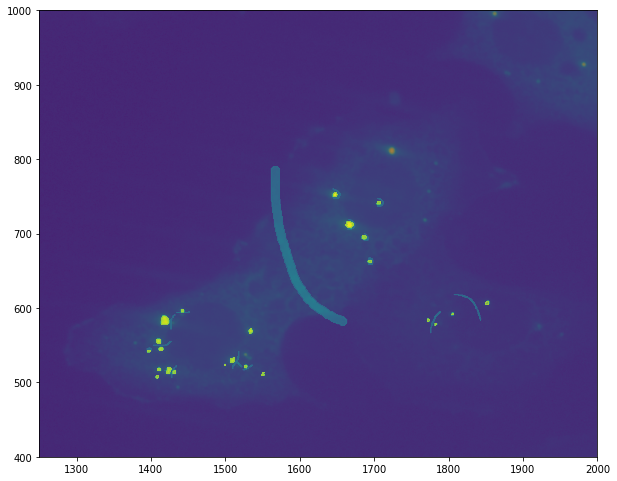

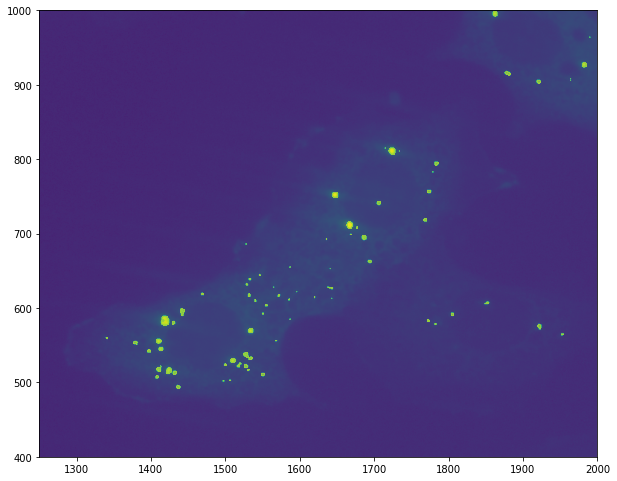

In [110]:
wellSite.display_labels(wellSite.labels, xlim=(1250, 2000), ylim=(400, 1000))
wellSite.display_labels(pred_labels, xlim=(1250, 2000), ylim=(400, 1000))

In [ ]:
# Test accuracy on testing labeled well sites
print("\n## Test ##")
for args in test_set:
    test_wellSite = WellSite(*args)
    print('\nPredicting labels for: '+test_wellSite.name)
    start = time.time()
    pred_labels = predict_segmenter(test_wellSite.generate_features(), clf)
    end = time.time()
    print('Completed. Time elapsed: '+str(np.around(end - start, 2))+'s')
    
    zipped = zip(pred_labels.flatten(), test_wellSite.labels.flatten())
    new_zipped = [(x, y) for x, y in zipped if y != 0]
    y_pred, y_true = zip(*new_zipped)
    print('    Accuracy score: '+str(np.around(accuracy_score(y_true, y_pred), 2)))
    print('    Balanced accuracy score: '+str(np.around(balanced_accuracy_score(y_true, y_pred), 2)))
    print(set(y_pred), set(y_true))
    props = test_wellSite.get_properties(pred_labels)
    print('Properties:')
    for key in props:
        print('    '+str(key)+': '+str(props[key]))

### Step 3: Use model to make predictions on some unlabeled well sites

In [ ]:
import pandas as pd
import datetime

unlabeled_well_sites = sorted(list(set([(s[:-7], TEST_DIR) for s in os.listdir(TEST_DIR)])))[1:]

csv_file_name = datetime.datetime.fromtimestamp(time.time()).isoformat()+'_results.csv'

df = pd.DataFrame()
for i in range(len(unlabeled_well_sites)):
    wellSite = WellSite(*unlabeled_well_sites[i])
    print('\n'+str(i)+'/'+str(len(unlabeled_well_sites)))
    print('Predicting labels for: '+wellSite.name)
    start = time.time()
    pred_labels = predict_segmenter(wellSite.generate_features(), clf)
    end = time.time()
    print('Completed. Time elapsed: '+str(np.around(end - start, 2))+'s')
    props = wellSite.get_properties(pred_labels)
    df = pd.concat((df, pd.DataFrame([props])))
    df.to_csv(csv_file_name) 

In [ ]:
# This snippet turns a csv into a cleaned nice per-well data summary
data = pd.read_csv('polyicyes_sites.csv').values

squashed_data = np.zeros((len(data), 6), dtype=('O'))

well = None
i = -1

avg_area = 0
avg_intensity = 0

for d in data:
    if d[1][:-3] != well:
        i += 1
        well = d[1][:-3]
        squashed_data[i][0] = well # name of well
        
    squashed_data[i][1] += d[2] # number of cells
    squashed_data[i][2] += d[3] # number of cells with condensates
    squashed_data[i][3] += d[4] # number of condensates
    
    if not np.isnan(d[6]):
        squashed_data[i][4] += d[6] * d[4] # sum of condensate areas
    if not np.isnan(d[7]):
        squashed_data[i][5] += d[7] * d[4] # sum of condensate intensity
    
squashed_data = [row for row in squashed_data if np.any(row)]
for row in squashed_data:
    if row[3] != 0:
        row[4] = np.around(row[4] / row[3], 3)
        row[5] = np.around(row[5] / row[3], 3)

# row[0]: Well Name
# row[1]: Number of Cells
# row[2]: Number of Cells with Condensates
# row[3]: Number of Condensates
# row[4]: Average Condensate Area
# row[5]: Average Condensate Intensity
for row in squashed_data:
    print(row)
    
df = pd.DataFrame(squashed_data, columns=['well', 'num_cells', 'num_cells_with_condensates', 'num_condensates', 'avg_condensate_area', 'avg_condensate_intensity'])

print(df)

df.to_csv('polyicyes.csv')

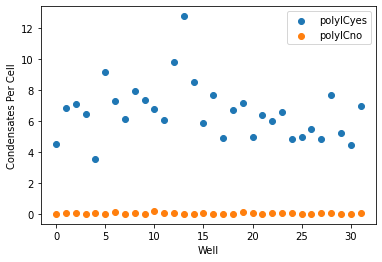

In [5]:
polyicyes_data = pd.read_csv('polyicyes.csv').values
polyicyes_avgs = np.divide(polyicyes_data[:,4],polyicyes_data[:,2])
polyicno_avgs = np.array([float(np.around(e, 2)) for e in polyicyes_avgs], dtype=(float))

polyicno_data = pd.read_csv('polyicno.csv').values
polyicno_avgs = np.divide(polyicno_data[:,4],polyicno_data[:,2])
polyicno_avgs = np.array([float(np.around(e, 2)) for e in polyicno_avgs], dtype=(float))

plt.scatter(polyicyes_data[:, 0], polyicyes_avgs, label='polyICyes')
plt.scatter(polyicyes_data[:, 0], polyicno_avgs, label='polyICno')
plt.ylabel('Condensates Per Cell')
plt.xlabel('Well')
plt.legend()